# LightGBM

https://lightgbm.readthedocs.io/en/latest/Python-Intro.html

In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from preprocess import Preprocess
import seaborn as sns

pd.set_option("display.max_columns", None)

Importing data and defining column names

In [3]:
data_path = "../../data/"
label_col = "Label"

train_df = pd.read_csv(data_path + "train.csv")
drop_cols = [
    # "time",
    "SNo"
]

train_df = train_df.drop(drop_cols, axis=1)
train_df = train_df.sort_values(by="Label")
# train_data = train_df.drop_duplicates(keep="last")
train_data = train_df.sample(frac=0.7)
validation_data = train_df.iloc[~train_data.index]

X = train_data.drop(["Label"], axis=1).copy()
y = train_data[label_col].copy()

X_valid = validation_data.drop(["Label"], axis=1).copy()
y_valid = validation_data[label_col].copy()

Squaring cols + magnitude of the wind

In [4]:
# X = preprocess(X)

In [5]:
preproc = Preprocess()

X = preproc.preprocess_data(train_data, drop_cols=[])
X_valid = preproc.preprocess_data(validation_data, drop_cols=[])

X = X.drop("Label", axis=1)
X_valid = X_valid.drop("Label", axis=1)

In [6]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)

scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
X_valid = scaler.fit_transform(X_valid)
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_valid, label=y_valid)

In [7]:
X_scaled.columns

Index(['lat', 'lon', 'TMQ', 'U850', 'V850', 'UBOT', 'VBOT', 'QREFHT', 'PS',
       'PSL', 'T200', 'T500', 'PRECT', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT',
       'time', 'month'],
      dtype='object')

Train lightgbm

In [58]:
# Define parameters (adjust these as per your needs)
parameters = {
    "objective": "multiclass",
    "num_class": 3,
#     'eval_metric': ["accuracy", "softmax"],
#     # "class_weight": {0: 1, 1: 3, 2:1.3},
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
    "max_bin": 2,
    "max_depth": 2,
    "num_leaves": 4,
#     "num_iterations": 200,
#     "n_jobs": 1,
#     "lambda_l1": 0.2,  # L1 regularization term. Adjust as needed.
#     "lambda_l2": 0.2,  # L2 regularization term. Adjust as needed.
#     # "verbose_eval": -1,
#     # "early_stopping_round": 4,
}

# # Train model
model_lgbm = lgb.LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3, num_leaves=8,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, objective="multiclass", num_class=3,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=-100)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
scores = cross_validate(model_lgbm, X=X_scaled, y=y,cv=5,scoring="accuracy")
model_lgbm.fit(X=X_scaled, y=y)

LGBMClassifier(max_depth=3, n_jobs=-1, num_class=3, num_leaves=8,
               objective='multiclass', random_state=123, verbose=-100)

com max depth = -1 e num leaves = 31

In [55]:
print("scores:", scores["test_score"])
print("mean:", scores["test_score"].mean())
print("diff :", scores["test_score"].max() - scores["test_score"].min())


scores: [0.89404819 0.88942078 0.8937121  0.89195659 0.89099904]
mean: 0.8920273390052852
diff : 0.004627413435455585


In [56]:
y_valid.value_counts()
confusion_matrix(y_valid, model_lgbm.predict(X=X_valid),)

array([[23554,   143,   888],
       [  387,   918,     4],
       [ 1643,    34,  3761]])

In [57]:
accuracy_score(model_lgbm.predict(X=X_valid), y_valid)

0.9010915358100344

In [ ]:
print("scores:", scores["test_score"])
print("mean:", scores["test_score"].mean())
print("diff :", scores["test_score"].max() - scores["test_score"].min())

scores: [0.87410244 0.8691559  0.87551867 0.87535908 0.87009256]
mean: 0.8728457306627092
diff : 0.006362776236189416


In [22]:
y_valid.value_counts()


0    24585
2     5438
1     1309
Name: Label, dtype: int64

In [23]:
confusion_matrix(y_valid, model_lgbm.predict(X=X_valid),)

array([[23428,    81,  1076],
       [  584,   725,     0],
       [ 2342,    39,  3057]])

In [24]:
accuracy_score(model_lgbm.predict(X=X_valid), y_valid)

0.8684412102642666

In [25]:
y_valid.value_counts(normalize=True)

0    0.784661
2    0.173561
1    0.041778
Name: Label, dtype: float64

In [26]:
pd.Series(model_lgbm.predict(X=X_valid)).value_counts(normalize=True)

0    0.841121
2    0.131910
1    0.026969
dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

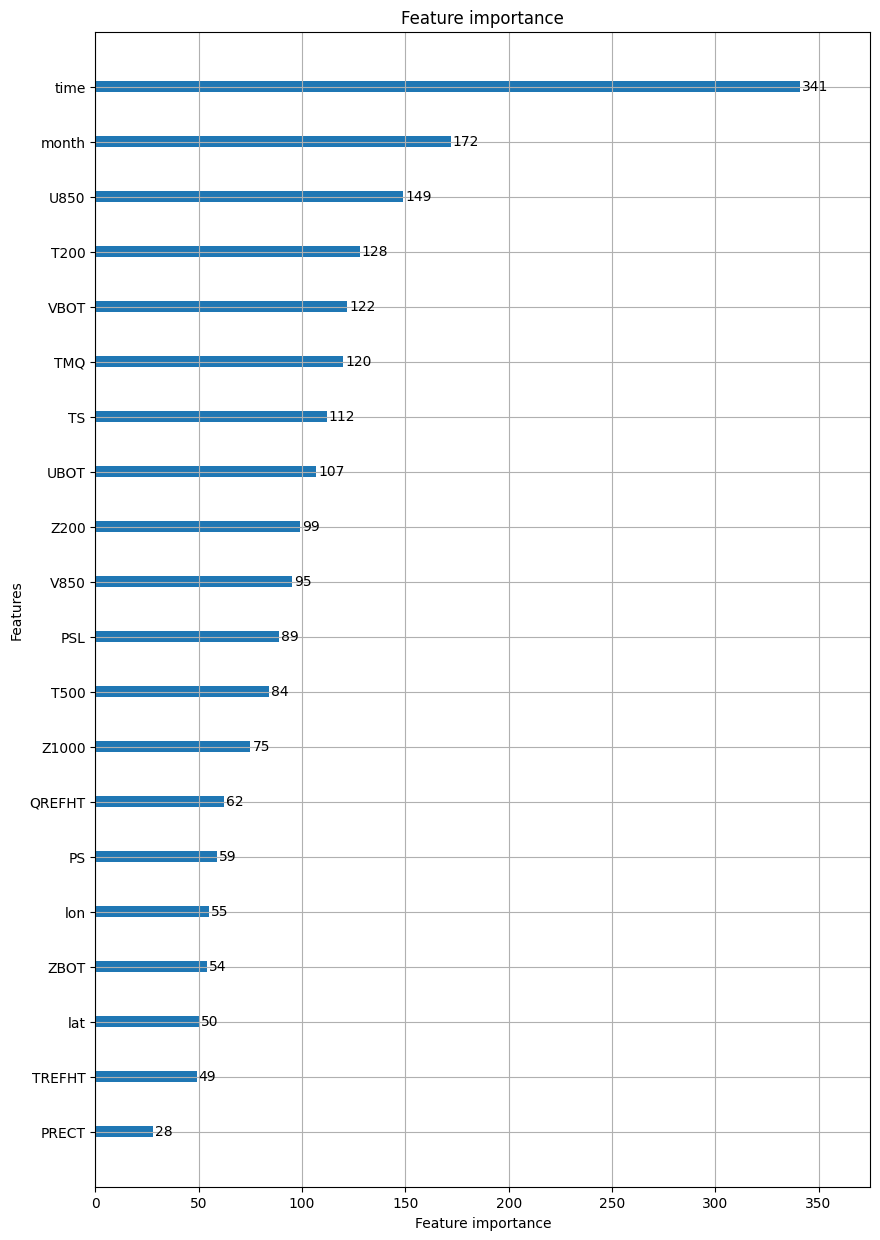

In [27]:
lgb.plot_importance(model_lgbm, height=0.2, figsize=(10,15))

In [59]:
test_data = pd.read_csv(data_path + "test.csv")

test_data_sel = test_data.drop(drop_cols, axis=1)
test_data_sel = preproc.preprocess_data(test_data, drop_cols=["SNo", "time"], is_test=True)

test_data_sel = scaler.fit_transform(test_data_sel)

<Axes: >

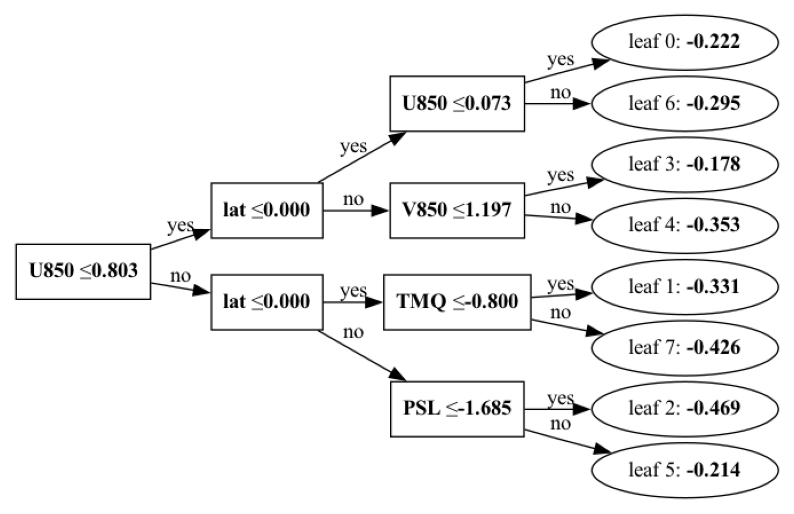

In [29]:
lgb.plot_tree(model_lgbm, figsize=(10,15))

In [108]:
submission = test_data[["SNo", "Label"]].copy()

In [110]:
# submition.drop("index", axis=1, inplace=True)
submission.to_csv(f"predictions_lightgbm_{datetime.now()}.csv", index=False)